In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import math
import os
import re
from gensim.models import word2vec
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import tempfile
import subprocess
import matplotlib.pyplot as plt 

RandomSeed = 42
np.random.seed(RandomSeed)


pd.set_option("display.max_colwidth", False)
pd.set_option('display.expand_frame_repr', False)
sns.set(font_scale = 1.2)

AA_array = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
       'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

kd = {"A": 1.8, "R": -4.5, "N": -3.5, "D": -3.5,
      "C": 2.5,  "Q": -3.5, "E": -3.5, "G": -0.4, "H": -3.2,
      "I": 4.5,
      "L": 3.8, "K": -3.9,
      "M": 1.9,
      "F": 2.8, "P": -1.6, "S": -0.8, "T": -0.7, "W": -0.9, "Y": -1.3,
      "V": 4.2} 


Hydrophobic_AAs = ['A', 'I', 'L', 'M', 'F', 'V']
Polar_AAs = ['S', 'Q', 'N', 'G', 'C', 'T', 'P']
Cation_AAs = ['K', 'R', 'H']
Anion_AAs = ['D', 'E']
Arom_AAs = ['W', 'Y', 'F']



def hydrophobicity(seq):
    sequence = ProteinAnalysis(seq)
    HB = 0
    for k in range(0, len(AA_array)):
        HB = HB + sequence.count_amino_acids()[AA_array[k]] * kd[AA_array[k]]        
    
    return HB


def Shannon_entropy(seq):
    sequence =  ProteinAnalysis(seq)
    entropy = 0
    for k in range(0, len(AA_array)):
        if sequence.get_amino_acids_percent()[AA_array[k]] == 0:
            entropy = entropy + 0
        else:
            entropy = entropy - math.log2(sequence.get_amino_acids_percent()[AA_array[k]]) * sequence.get_amino_acids_percent()[AA_array[k]]        
    
    return entropy




def extract_IDR(seq):
    tmp_IDR = tempfile.NamedTemporaryFile()  
    with open(tmp_IDR.name, 'w') as f_IDR:
         f_IDR.write('>1\n' + str(seq))
    tmp_IDR.seek(0)
    
    out = subprocess.Popen(['python', 'iupred2a.py', str(tmp_IDR.name), 'long'], 
           stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    stdout_IDR, stderr_IDR = out.communicate()
    stdout_IDR = stdout_IDR.split()[40:]
    
    IDR_prob = []
    for i in range(0, int(len(stdout_IDR)/3)):
        IDR_prob.append(float(str(stdout_IDR[3*i + 2], 'utf-8')))
       
    TH1 = 0.5
    TH2 = 20
    AAs   = pd.Series(list(map(lambda i:i, seq)))    
    IDR_residues = []
    current = 0
    for t in range(0, len(IDR_prob)):
        if IDR_prob[t] > TH1:
            current = current + 1
            if t == len(IDR_prob) - 1:
                if current > TH2:
                    IDR_residues.extend(range(t - current , t + 1))
        else:
            if current > TH2:
                IDR_residues.extend(range(t - current , t + 1))
                current = 0
            else:
                current = 0
    #IDR_seq = AAs[IDR_residues].str.cat()
    
    return len(IDR_residues)#, IDR_seq


def get_AA_count(seq, AA):
    if type(seq) == float:
        count = 0
    else:
        sequence = ProteinAnalysis(seq)
        count = sequence.count_amino_acids()[str(AA)]
    return count


def phys_features(sequence):
   # Evaluate sequence specific parameters that the model uses:
    df = pd.DataFrame({'Sequence' : [sequence]})
    df['Sequence_length'] = df['Sequence'].str.len()
    df['Hydrophobicity'] = hydrophobicity(str(df['Sequence']))
    df['Shannon_entropy'] = Shannon_entropy(str(df['Sequence'])) 
    
    IDR_reg = extract_IDR(df['Sequence'].item())
    #df['IDR_sequence']  = IDR_reg[1]
    df['IDR_fraction']  = IDR_reg / df['Sequence_length']
    
    # and also the amino acid composition specific features that the model uses:
    for k in range(0, len(AA_array)):
        df['AA_' + str(AA_array[k])] = [get_AA_count(seq, str(AA_array[k])) for seq in df['Sequence']]
    df['Polar'] = 0; df['Cation'] = 0; df['Arom'] = 0;
    for i in range(0, len(Polar_AAs)):
        df['Polar']  = df['Polar']  + df['AA_' + str(Polar_AAs[i])]
    for i in range(0, len(Arom_AAs)):
        df['Arom']  = df['Arom']  + df['AA_' + str(Arom_AAs[i])]
    for i in range(0, len(Cation_AAs)):
        df['Cation']  = df['Cation']  + df['AA_' + str(Cation_AAs[i])]
    df = df.loc[:,~df.columns.str.startswith('AA_')]
    df['Polar_frac'] = (df['Polar']  / df["Sequence_length"]).replace(np.nan, 0)
    df['Cation_frac'] = (df['Cation']  / df["Sequence_length"]).replace(np.nan, 0)
    df['Arom_frac'] = (df['Arom']  / df["Sequence_length"] ).replace(np.nan, 0)
    
    df = df.drop(columns={'Polar', 'Arom', 'Cation'})
    
    return df



In [2]:
myseq = 'MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGGGGGGGGGGNYGQDQSSMSSGGGSGGGYGNQDQSGGGGSGGYGQQDRGGRGRGGSGGGGGGGGGGYNRSSGGYEPRGRGGGRGGRGGMGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGGGNGRGGRGRGGPMGRGGYGGGGSGGGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPGGGPGGSHMGGNYGDDRRGGRGGYDRGGYRGRGGDRGGFRGGRGGGDRGGFGPGKMDSRGEHRQDRRERPY'
phys_features(myseq)

,Sequence,Sequence_length,Hydrophobicity,Shannon_entropy,IDR_fraction,Polar_frac,Cation_frac,Arom_frac
0,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGGGGGGGGGGNYGQDQSSMSSGGGSGGGYGNQDQSGGGGSGGYGQQDRGGRGRGGSGGGGGGGGGGYNRSSGGYEPRGRGGGRGGRGGMGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGGGNGRGGRGRGGPMGRGGYGGGGSGGGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPGGGPGGSHMGGNYGDDRRGGRGGYDRGGYRGRGGDRGGFRGGRGGGDRGGFGPGKMDSRGEHRQDRRERPY,526,-698.3,3.398065,0.89924,0.657795,0.102662,0.098859


In [3]:
df = pd.read_csv('w2v_nonnorm_LLPS_PDB_RF.csv', sep='\t')
df = df[(df['Category'] == 'LLPS+')]
df.drop_duplicates(subset ='Uniprot_ID', keep = 'first', inplace = True)
df.index = df['Uniprot_ID']
df=df.drop(['Uniprot_ID', 'Category'], axis = 1)
df.columns = ['LLPS_PDB_RF']
df

,LLPS_PDB_RF
Uniprot_ID,
Q9UHD9,1.000
P04147,1.000
Q13151,1.000
P22626,1.000
P09651-1,1.000
...,...
P08908,0.770
Q60598,0.745
Q41372,0.690


In [4]:
df1 = pd.read_csv('w2v_nonnorm_LLPS_LLPS_RF.csv', sep='\t')
df1 = df1[(df1['Category'] == 'LLPS+')]
df1.drop_duplicates(subset ='Uniprot_ID', keep = 'first', inplace = True)
df1.index = df1['Uniprot_ID']
df1=df1.drop(['Uniprot_ID', 'Category'], axis = 1)
df1.columns = ['LLPS_LLPS_RF']


In [5]:
df2 = pd.read_csv('Phys_features_LLPS_PDB_RF.csv', sep='\t')
df2 = df2[(df2['Category'] == 'LLPS+')]
df2.drop_duplicates(subset ='Uniprot_ID', keep = 'first', inplace = True)
df2.index = df2['Uniprot_ID']
df2=df2.drop(['Uniprot_ID', 'Category'], axis = 1)
df2.columns = ['Phys_feat_LLPS_PDB_RF']


In [6]:
df3 = pd.read_csv('Phys_features_LLPS_LLPS_RF.csv', '\t')
df3 = df3[(df3['Category'] == 'LLPS+')]
df3.drop_duplicates(subset ='Uniprot_ID', keep = 'first', inplace = True)
df3.index = df3['Uniprot_ID']
df3=df3.drop(['Category', 'Uniprot_ID'], axis = 1)
df3.columns = ['Phys_feat_LLPS_LLPS_RF']


In [7]:
true_llps = pd.read_csv('LLPS_sequences_final.csv')
true_llps=true_llps[(true_llps['Category'] == 'LLPS_easy')]
true_llps=true_llps.rename(columns={"Uniprot_ID": "Entry"})
true_llps.index=true_llps['Entry']
true_llps=true_llps.drop(['LLPS?', 'Category', 'Unnamed: 0', 'Entry', 'Full_length', 'Construct_length', 'Full_sequence'], axis=1)
true_llps

,Construct_sequence
Entry,
D0PV95,MESNQSNNGGSGNAALNRGGRYVPPHLRGGDGGAAAAASAGGDDRRGGAGGGGYRRGGGNSGGGGGGGYDRGYNDNRDDRDNRGGSGGYGRDRNYEDRGYNGGGGGGGNRGYNNNRGGGGGGYNRQDRGDGGSSNFSRGGYNNRDEGSDNRGSGRSYNNDRRDNGGDGQNTRWNNLDAPPSRGTSKWENRGARDERIEQELFSGQLSGINFDKYEEIPVEATGDDVPQPISLFSDLSLHEWIEENIKTAGYDRPTPVQKYSIPALQGGRDLMSCAQTGSGKTAAFLVPLVNAILQDGPDAVHRSVTSSGGRKKQYPSALVLSPTRELSLQIFNESRKFAYRTPITSALLYGGRENYKDQIHKLRLGCHILIATPGRLIDVMDQGLIGMEGCRYLVLDEADRMLDMGFEPQIRQIVECNRMPSKEERITAMFSATFPKEIQLLAQDFLKENYVFLAVGRVGSTSENIMQKIVWVEEDEKRSYLMDLLDATGDSSLTLVFVETKRGASDLAYYLNRQNYEVVTIHGDLKQFEREKHLDLFRTGTAPILVATAVAARGLDIPNVKHVINYDLPSDVDEYVHRIGRTGRVGNVGLATSFFNDKNRNIARELMDLIVEANQELPDWLEGMSGDMRSGGGYRGRGGRGNGQRFGGRDHRYQGGSGNGGGGNGGGGGFGGGGQRSGGGGGFQSGGGGGRQQQQQQRAQPQQDWWS
D0PV95,MESNQSNNGGSGNAALNRGGRYVPPHLRGGDGGAAAAASAGGDDRRGGAGGGGYRRGGGNSGGGGGGGYDRGYNDNRDDRDNRGGSGGYGRDRNYEDRGYNGGGGGGGNRGYNNNRGGGGGGYNRQDRGDGGSSNFSRGGYNNRDEGSDNRGSGRSYNNDRRDNGGDGQNTRWNNLDAPPSRGTSKWENRGARDERIEQELFSGQLSGINFDKYEEIPVEATGDDVPQPISLFSDLSLHEWIEENIKTAGYDRPTPVQKYSIPALQGGRDLMSCAQTGSGKTAAFLVPLVNAILQDGPDAVHRSVTSSGGRKKQYPSALVLSPTRELSLQIFNESRKFAYRTPITSALLYGGRENYKDQIHKLRLGCHILIATPGRLIDVMDQGLIGMEGCRYLVLDEADRMLDMGFEPQIRQIVECNRMPSKEERITAMFSATFPKEIQLLAQDFLKENYVFLAVGRVGSTSENIMQKIVWVEEDEKRSYLMDLLDATGDSSLTLVFVETKRGASDLAYYLNRQNYEVVTIHGDLKQFEREKHLDLFRTGTAPILVATAVAARGLDIPNVKHVINYDLPSDVDEYVHRIGRTGRVGNVGLATSFFNDKNRNIARELMDLIVEANQELPDWLEGMSGDMRSGGGYRGRGGRGNGQRF
D0PV95,ESNQSNNGGSGNAALNRGGRYVPPHLRGGDGGAAAAASAGGDDRRGGAGGGGYRRGGGNSGGGGGGGYDRGYNDNRDDRDNRGGSGGYGRDRNYEDRGYNGGGGGGGNRGYNNNRGGGGGGYNRQDRGDGGSSNFSRGGYNNRDEGSDNRGSGRSYNNDRRDNGGDG
P35637,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGGGGGGGGGGNYGQDQSSMSSGGGSGGGYGNQDQSGGGGSGGYGQQDRGGRGRGGSGGGGGGGGGGYNRSSGGYEPRGRGGGRGGRGGMGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGGGNGRGGRGRGGPMGRGGYGGGGSGGGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPGGGPGGSHMGGNYGDDRRGGRGGYDRGGYRGRGGDRGGFRGGRGGGDRGGFGPGKMDSRGEHRQDRRERPY
P35637,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGGGGGGGGGGNYGQDQSSMSSGGGSGGGYGNQDQSGGGGSGGYGQQDRGGRGRGGSGGGGGGGGGGYNRSSGGYEPRGRGGGRGGRGGMGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGGGNGRGGRGRGGPMGRGGYGGGGSGGGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPGGGPGGSHMGGNYGDDRRGGRGGYDRGGYRGRGGDRGGFRGGRGGG
...,...
P10636-8,QTAPVPMPDLKNVKSKIGSTENLKHQPGGGKVQIINKKLDLSNVQSKCGSKDNIKHVPGGGSVQIVYKPVDLSKVTSKCGSLGNIHHKPGGGQVEVKSEKLDFKDRVQSKIGSLDNITHVPGGGNKKIE
P35637,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGGGGGGGGGGNYGQDQSSMSSGGGSGGGYGNQDQSGGGGSGGYGQQDRGGRGRGGSGGGGGGGGGGYNRSSGGYEPRGRGGGRGGRGGMGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGGGNGRGGRGRGGPMGRGGYGGGGSGGGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPGGGPGGSHMGGNYGDDRRGGRGGYDRGGYRGRGGDRGGF
P08908,MDVLSPGQGNNTTSPPAPFETGGNTTGISDVTVSYQVITSLLLGTLIFCAVLGNACVVAAIALERSLQNVANYLIGSLAVTDLMVSVLVLPMAALYQVLNKWTLGQVTCDLFIALDVLCCTSSILHLCAIALDRYWAITDPIDYVNKRTPRRAAALISLTWLIGFLISIPPMLGWRTPEDRSDPDACTISKDHGYTIYSTFGAFYIPLLLMLVLYGRIFRAARFRIRKTVKKVEKTGADTRHGASPAPQPKKSVNGESGSRNWRLGVESKAGGALCANGAVRQGDDGAALEVIEVHRVGNSKEHLPLPSEAGPTPCAPASFERKNERNAEAKRKMALARERKTVKTLGIIMGTFILCWLPFFIVALVLPFCESSCHMPTLLGAIINWLGYSNSLLNPVIYAYFNKDFQNAFKKIIKCKFCRQ


In [8]:
exs = pd.read_excel('uniprot-filtered-organism__Homo+sapiens+(Human)+(9606)_+AND+review--.xlsx')
exs.index = exs['Entry']
exs = exs.drop(['Entry', 'Entry name', 'Protein names', 'Gene names', 'Status', 'Gene ontology (biological process)', 'Gene ontology (cellular component)', 'Gene ontology (molecular function)', 'Gene ontology (GO)', 'Gene ontology IDs'], axis=1)
exs

,Sequence
Entry,
Q8N7X0,MASKQTKKKEVHRINSAHGSDKSKDFYPFGSNVQSGSTEQKKGKFPLWPEWSEADINSEKWDAGKGAKEKDKTGKSPVFHFFEDPEGKIELPPSLKIYSWKRPQDILFSQTPVVVKNEITFDLFSANEHLLCSELMRWIISEIYAVWKIFNGGILSNYFKGTSGEPPLLPWKPWEHIYSLCKAVKGHMPLFNSYGKYVVKLYWMGCWRKITIDDFLPFDEDNNLLLPATTYEFELWPMLLSKAIIKLANIDIHVADRRELGEFTVIHALTGWLPEVISLHPGYMDKVWELLKEILPEFKLSDEASSESKIAVLDSKLKEPGKEGKEGKEIKDGKEVKDVKEFKPESSLTTLKAPEKSDKVPKEKADARDIGKKRSKDGEKEKFKFSLHGSRPSSEVQYSVQSLSDCSSAIQTSHMVVYATFTPLYLFENKIFSLEKMADSAEKLREYGLSHICSHPVLVTRSRSCPLVAPPKPPPLPPWKLIRQKKETVITDEAQELIVKKPERFLEISSPFLNYRMTPFTIPTEMHFVRSLIKKGIPPGSDLPSVSETDETATHSQTDLSQITKATSQGNTASQVILGKGTDEQTDFGLGDAHQSDGLNLEREIVSQTTATQEKSQEELPTTNNSVSKEIWLDFEDFCVCFQNIYIFHKPSSYCLNFQKSEFKFSEERVSYYLFVDSLKPIELLVCFSALVRWGEYGALTKDSPPIEPGLLTAETFSWKSLKPGSLVLKIHTYATKATVVRLPVGRHMLLFNAYSPVGHSIHICSMVSFVIGDEHVVLPNFEPESCRFTEQSLLIMKAIGNVIANFKDKGKLSAALKDLQTAHYPVPFHDKELTAQHFRVFHLSLWRLMKKVQITKPPPNFKFAFRAMVLDLELLNSSLEEVSLVEWLDVKYCMPTSDKEYSAEEVAAAIKIQAMWRGTYVRLLMKARIPDTKENISVADTLQKVWAVLEMNLEQYAVSLLRLMFKSKCKSLESYPCYQDEETKIAFADYTVTYQEQPPNSWFIVFRETFLVHQDMILVPKVYTTLPICILHIVNNDTMEQVPKVFQKVVPYLYTKNKKGYTFVAEAFTGDTYVAASRWKLRLIGSSAPLPCLSRDSPCNSFAIKEIRDYYIPNDKKILFRYSVKVLTPQPATIQVRTSKPDAFIKLQVLENEETMVSSTGKGQAIIPAFHFLKSEKGLSSQSSKHILSFHSASKKEQEVYVKKKAAQGIQKSPKGRAVSAIQDIGLPLVEEETTSTPTREDSSSTPLQNYKYIIQCSVLYNSWPLTESQLTFVQALKDLKKSNTKAYGERHEELINLGSPDSHTISEGQKSSVTSKTTRKGKEKSSEKEKTAKEKQAPRFEPQISTVHPQQEDPNKPYWILRLVTEHNESELFEVKKDTERADEIRAMKQAWETTEPGRAIKASQARLHYLSGFIKKTSDAESPPISESQTKPKEEVETAARGVKEPNSKNSAGSESKEMTQTGSGSAVWKKWQLTKGLRDVAKSTSSESGGVSSPGKEEREQSTRKENIQTGPRTRSPTILETSPRLIRKALEFMDLSQYVRKTDTDPLLQTDELNQQQAMQKAEEIHQFRQHRTRVLSIRNIDQEERLKLKDEVLDMYKEMQDSLDEARQKIFDIREEYRNKLLEAEHLKLETLAAQEAAMKLETEKMTPAPDTQKKKKGKKK
Q5T1N1,MDEADFSEHTTYKQEDLPYDGDLSQIKIGNDYSFTSKKDGLEVLNQIIFIADDPQEKAMHSETCGNTAVTIPLGKITENAANKKDEKEKQCTAALHIPANEGDASKSSISDILLHHLSKEPFLRGQGIDCETLPEISNADSFEEEAIIKSIISCYNKNSWPKEQTPELTDQLNPKRDGENSNKPGSATTTEENTSDLEGPVAAGDSSHQENVNVLTKTKGPGDKQKSYQGQSPQKQQTEKANSGNTFKYGQGQVHYQLPDFSKIAPKVKIPKNKIINKPLAIAKQASFSSKSRDKPTLVQDSLETTPESNCVEKQHQEQKGKITEPSQQIQMEPIVHIHQELLTGIESEASLSKLSPTSQKGTSSSSSYIFQKISQGKQMCQKLKEQTDQLKTKVQEFSKRIKQDSPYHLQDKKLVLEKLQGHLELLEQNFLATKDKHLTLQQQVHKHESTIVGDFDPERKVEGEIFKLEMLLEDVKEKMDESKYTSAPSLPVSSPVTLDDLASTFSSLSNEIPKEHPGHPSGPRGSGGSEVTGTPQGGPQEAPNEELCELAPQTYLNGHYGDAAAQNKPDQVAMRLSSNSGEDPNGTPRRQDCAEMTAPSPSCAFCRRLLEWKQNVEKKGHGRINCGRFSIVLHEKAPHSDSTPNSDTGHSFCSDSGTEMQSNKCQDCGTKIPTSRRACRKEPTKEFHYRYNTPGQNYSNHSKRGAFVQPHSLDESKNSSPSFLKPKRICSQRVNSKSFKGEHEPTPGKKKLQAFMTYSSDPATPSPHFYSCRISGSKSLCDFDSTEEIKSEILNSALDHALRTATILKETTDQMIKTIAEDLAKAQRWRNRLKY
Q92667,MAIQFRSLFPLALPGMLALLGWWWFFSRKKGHVSSHDEQQVEAGAVQLRADPAIKEPLPVEDVCPKVVSTPPSVTEPPEKELSTVSKLPAEPPALLQTHPPCRRSESSGILPNTTDMRLRPGTRRDDSTKLELALTGGEAKSIPLECPLSSPKGVLFSSKSAEVCKQDSPFSRVPRKVQPGYPVVPAEKRSSGERARETGGAEGTGDAVLGEKVLEEALLSREHVLELENSKGPSLASLEGEEDKGKSSSSQVVGPVQEEEYVAEKLPSRFIESAHTELAKDDAAPAPPVADAKAQDRGVEGELGNEESLDRNEEGLDRNEEGLDRNEESLDRNEEGLDRNEEIKRAAFQIISQVISEATEQVLATTVGKVAGRVCQASQLQGQKEESCVPVHQKTVLGPDTAEPATAEAAVAPPDAGLPLPGLPAEGSPPPKTYVSCLKSLLSSPTKDSKPNISAHHISLASCLALTTPSEELPDRAGILVEDATCVTCMSDSSQSVPLVASPGHCSDSFSTSGLEDSCTETSSSPRDKAITPPLPESTVPFSNGVLKGELSDLGAEDGWTMDAEADHSGGSDRNSMDSVDSCCSLKKTESFQNAQAGSNPKKVDLIIWEIEVPKHLVGRLIGKQGRYVSFLKQTSGAKIYISTLPYTQSVQICHIEGSQHHVDKALNLIGKKFKELNLTNIYAPPLPSLALPSLPMTSWLMLPDGITVEVIVVNQVNAGHLFVQQHTHPTFHALRSLDQQMYLCYSQPGIPTLPTPVEITVICAAPGADGAWWRAQVVASYEETNEVEIRYVDYGGYKRVKVDVLRQIRSDFVTLPFQGAEVLLDSVMPLSDDDQFSPEADAAMSEMTGNTALLAQVTSYSPTGLPLIQLWSVVGDEVVLINRSLVERGLAQWVDSYYTSL
Q5VUY0,MWDLALIFLAAACVFSLGVTLWVICSHFFTVHIPAAVGHPVKLRVLHCIFQLLLTWGMIFEKLRICSMPQFFCFMQDLPPLKYDPDVVVTDFRFGTIPVKLYQPKASTCTLKPGIVYYHGGGGVMGSLKTHHGICSRLCKESDSVVLAVGYRKLPKHKFPVPVRDCLVATIHFLKSLDAYGVDPARVVVCGDSFGGAIAAVVCQQLVDRPDLPRIRAQILIYAILQALDLQTPSFQQRKNIPLLTWSFICYFFFQNLDFSSSWQEVIMKGAHLPAEVWEKYRKWLGPENIPERFKERGYQLKPHEPMNEAAYLEVSVVLDVMCSPLIAEDDIVSQLPETCIVSCEYDALRDNSLLYKKRLEDLGVPVTWHHMEDGFHGVLRTIDMSFLHFPCSMRILSALVQFVKGL
P62736,MCEEEDSTALVCDNGSGLCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIITNWDDMEKIWHHSFYNELRVAPEEHPTLLTEAPLNPKANREKMTQIMFETFNV

In [9]:
sequences = true_llps['Construct_sequence'].tolist()

In [10]:
temp_c = [phys_features(t) for t in sequences]
temp_c_df = pd.concat(temp_c)
temp_c_df.index = true_llps.index
temp_c_df = temp_c_df.drop(['Sequence'], axis=1)
temp_c_df

,Sequence_length,Hydrophobicity,Shannon_entropy,IDR_fraction,Polar_frac,Cation_frac,Arom_frac
Entry,,,,,,,
D0PV95,708,-591.7,3.864046,0.413842,0.436441,0.135593,0.077684
D0PV95,647,-498.3,3.889436,0.315301,0.404946,0.139104,0.077280
D0PV95,167,-292.9,2.634421,1.005988,0.586826,0.149701,0.071856
P35637,526,-698.3,3.398065,0.899240,0.657795,0.102662,0.098859
P35637,501,-640.6,3.369530,0.894212,0.672655,0.091816,0.099800
...,...,...,...,...,...,...,...
P10636-8,129,-90.1,3.278849,0.480620,0.449612,0.201550,0.015504
P35637,494,-629.6,3.381825,0.888664,0.672065,0.089069,0.101215
P08908,422,78.1,3.934198,0.063981,0.355450,0.118483,0.085308


In [11]:
with open('nw.pkl', 'rb') as f:
    mynewlist = pickle.load(f)

In [12]:
df4=exs.loc[mynewlist]
test_seq = df4['Sequence'].tolist()

In [13]:
test = [phys_features(t) for t in test_seq]
test_df = pd.concat(test)
test_df.index = df4.index
test_df = test_df.drop(['Sequence'], axis=1)
#test_df.style.bar(align='mid', color=['red', 'lightgreen'])
test_df

,Sequence_length,Hydrophobicity,Shannon_entropy,IDR_fraction,Polar_frac,Cation_frac,Arom_frac
Entry,,,,,,,
O15116,133,-48.8,3.427337,0.000000,0.263158,0.157895,0.045113
O43561,262,-115.9,3.656444,0.648855,0.423664,0.072519,0.061069
O43663,620,-447.4,3.936272,0.246774,0.324194,0.170968,0.056452
O43791,374,-95.5,3.921510,0.000000,0.310160,0.136364,0.090909
O43809,227,-94.1,3.775225,0.000000,0.352423,0.140969,0.114537
...,...,...,...,...,...,...,...
Q9Y333,95,-15.0,3.324463,0.000000,0.305263,0.136842,0.084211
Q9Y4Y9,91,3.2,3.239256,0.000000,0.351648,0.087912,0.032967
Q9Y4Z0,139,-108.2,3.509798,0.388489,0.417266,0.187050,0.050360


In [14]:
train_percentiles=np.percentile(temp_c_df['Sequence_length'], range(0,101))

In [15]:
def percentilator(s, lst):
    left = 0
    right=len(lst)-1
    center = (left+right)//2
    
    if s>lst[right]:
        return '100%'
    elif s<lst[left]:
        return '-1%'
    if s==lst[center]:
        return center
    
    while left<center:
        if s ==lst[center]:
            return center
        elif s>lst[center]:
            left=center
        else:
            right=center
        center = (left+right)//2
    return center

In [16]:
train_df=pd.DataFrame(temp_c_df)
train_dict={}

columns = list(train_df) 
for i in columns:
    train_dict[i]=np.percentile(train_df[i], range(0,101))
    
train_dict

{'Sequence_length': array([  69.  ,   87.52,   97.04,  100.48,  116.12,  129.8 ,  135.96,
         144.64,  148.88,  152.  ,  152.  ,  155.84,  169.56,  176.36,
         179.48,  191.4 ,  193.52,  198.96,  207.44,  210.68,  211.4 ,
         226.44,  244.36,  246.  ,  246.  ,  247.  ,  258.68,  272.04,
         281.  ,  282.32,  284.8 ,  297.44,  305.  ,  310.28,  311.24,
         312.6 ,  313.96,  315.64,  319.04,  327.56,  341.  ,  344.8 ,
         352.12,  353.96,  359.2 ,  370.4 ,  375.36,  378.  ,  382.28,
         384.92,  386.  ,  392.72,  399.04,  406.24,  409.  ,  413.  ,
         420.32,  430.84,  439.88,  441.  ,  445.2 ,  448.96,  452.  ,
         452.  ,  453.04,  457.2 ,  469.6 ,  474.72,  486.72,  494.  ,
         500.2 ,  507.72,  513.  ,  516.84,  520.92,  523.  ,  524.72,
         528.16,  532.96,  550.6 ,  568.6 ,  573.32,  576.04,  581.4 ,
         590.44,  596.2 ,  615.24,  624.96,  639.92,  647.36,  658.4 ,
         674.16,  685.96,  698.76,  707.52,  729.2 ,  761.

In [17]:
test_df1=pd.DataFrame(test_df)

columns = list(train_df) 
for i in columns:
    test_df1[i] = test_df1[i].apply(lambda x: percentilator(x, train_dict[i]))
test_df1

,Sequence_length,Hydrophobicity,Shannon_entropy,IDR_fraction,Polar_frac,Cation_frac,Arom_frac
Entry,,,,,,,
O15116,5,95,30,3,-1%,74,23
O43561,26,86,46,65,33,13,29
O43663,86,20,87,25,4,88,26
O43791,45,90,84,3,2,49,61
O43809,21,90,64,3,11,53,87
...,...,...,...,...,...,...,...
Q9Y333,1,96,23,3,2,50,52
Q9Y4Y9,1,97,19,3,10,17,12
Q9Y4Z0,6,88,33,39,31,94,24


In [18]:
pluses=pd.read_csv('pluses.csv')
pluses=pluses.rename(columns = {'Unnamed: 0':'Entry'})
pluses.index=pluses['Entry']
pluses=pluses.drop(['Entry'], axis=1)
pluses

,w2v_LLPS_PDB_RF,Phys_feat_LLPS_PDB_RF,w2v_LLPS_LLPS_RF,Phys_feat_LLPS_LLPS_RF
Entry,,,,
O00401,+,+,+,+
O14641,+,+,+,+
O15116,-,-,-,-
O15169,+,+,+,+
O15550,+,+,+,+
...,...,...,...,...
Q9Y3R0,+,+,+,+
Q9Y4Y9,-,-,+,-
Q9Y4Z0,-,+,-,-


In [19]:
result=pd.merge(test_df1, pluses, on='Entry')
result.to_csv('pluses_minuses.csv')

In [20]:
test_df1.to_csv('percentiles.csv')

In [21]:
with open('work.pkl', 'rb') as f:
    mynewlist1 = pickle.load(f)

In [22]:
df5=exs.loc[mynewlist1]
wtest_seq = df5['Sequence'].tolist()

wtest = [phys_features(t) for t in wtest_seq]
wtest_df = pd.concat(wtest)
wtest_df.index = df5.index
wtest_df = wtest_df.drop(['Sequence'], axis=1)
wtest_df.style.bar(align='mid', color=['red', 'lightgreen'])

,Sequence_length,Hydrophobicity,Shannon_entropy,IDR_fraction,Polar_frac,Cation_frac,Arom_frac
Entry,,,,,,,
O00401,505,-426.200000,3.846972,0.704950,0.465347,0.134653,0.053465
O14641,736,-421.300000,3.911254,0.464674,0.449728,0.119565,0.063859
O15169,862,-688.600000,4.007694,0.548724,0.370070,0.172854,0.062645
O15550,1401,-647.500000,4.096787,0.336188,0.434690,0.122769,0.072805
O43390,633,-594.800000,3.950264,0.325434,0.368088,0.161137,0.099526
O43670,478,-309.100000,3.758483,0.845188,0.525105,0.106695,0.043933
O43781,588,-266.800000,4.028148,0.159864,0.375850,0.170068,0.079932
O60479,287,-245.800000,3.727461,0.439024,0.473868,0.125436,0.101045
O75177,396,-405.600000,3.541574,0.828283,0.601010,0.060606,0.090909


In [23]:
with open('all.pkl', 'rb') as f:
    mynewlist2 = pickle.load(f)

In [24]:
df6=exs.loc[mynewlist2]
test_all = df6['Sequence'].tolist()

test = [phys_features(t) for t in test_all]
test_all = pd.concat(test)
test_all.index = df6.index
test_all = test_all.drop(['Sequence'], axis=1)
test_all.style.bar(align='mid', color=['red', 'lightgreen'])

TypeError: '<=' not supported between instances of 'int' and 'str'

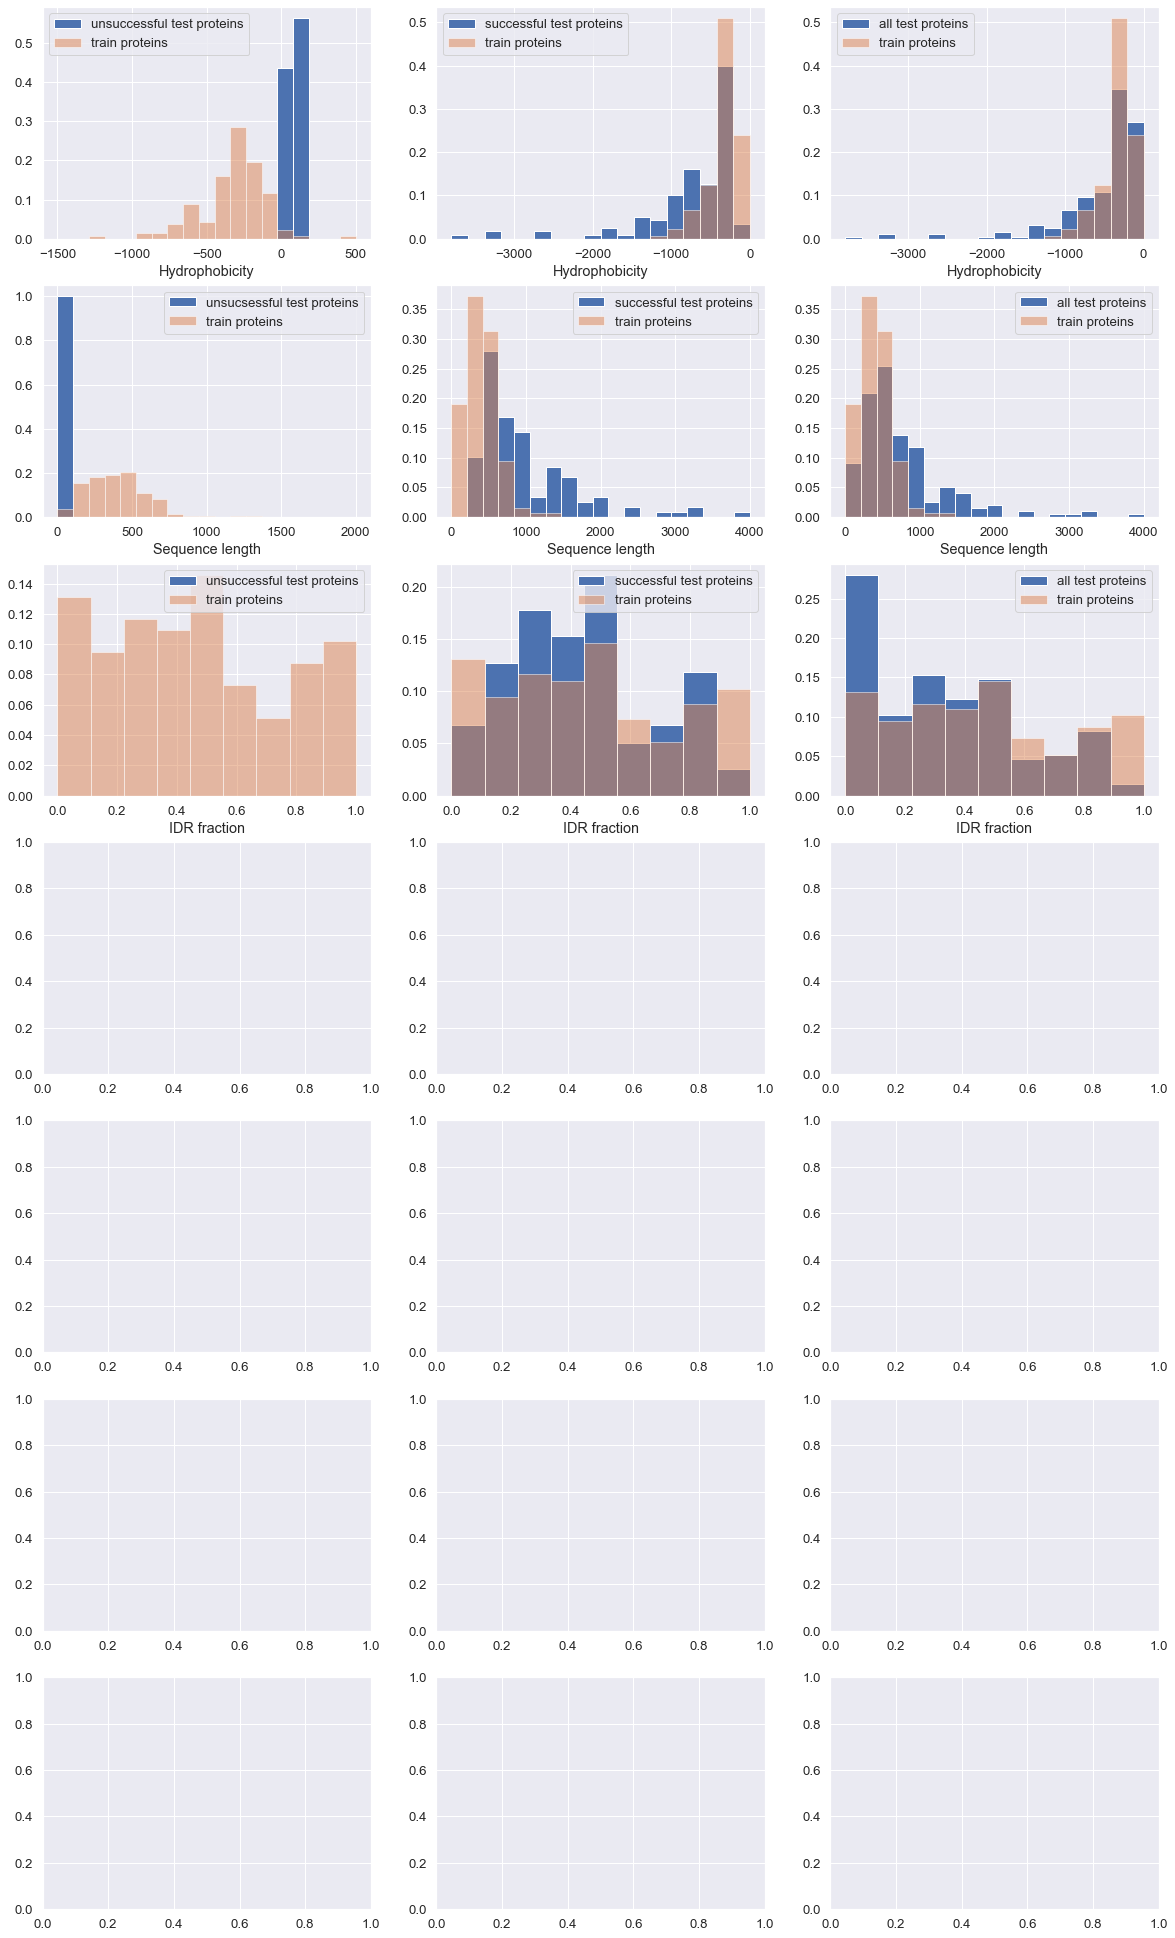

In [25]:
fig, ax = plt.subplots(7, 3, figsize = (20,35))

bins = np.linspace(-0.001, 2000, 20)
bins1 = np.linspace(-0.001, 4000, 20)
binsh=np.linspace(-1500, 500, 20)
binsh1=np.linspace(-3800,0,19)
bins_IDR=np.linspace(0,1,10)
binss=np.linspace(3,4,10)
binsp=np.linspace(0.2,0.7,10)
binsc=np.linspace(0,0.3,12)
binsa=np.linspace(0,0.2,16)


ax[0][0].hist([test_df['Hydrophobicity']], binsh, weights=np.ones(len(test_df['Hydrophobicity'])) / len(test_df['Hydrophobicity']), alpha=1, label='unsuccessful test proteins')
ax[0][0].hist([temp_c_df['Hydrophobicity']], binsh, weights=np.ones(len(temp_c_df['Hydrophobicity'])) / len(temp_c_df['Hydrophobicity']), alpha=0.5, label='train proteins')
ax[0][0].legend(loc='upper left')
ax[0][0].set_xlabel('Hydrophobicity')


ax[0][1].hist([wtest_df['Hydrophobicity']], binsh1, weights=np.ones(len(wtest_df['Hydrophobicity'])) / len(wtest_df['Hydrophobicity']), alpha=1, label='successful test proteins')
ax[0][1].hist([temp_c_df['Hydrophobicity']], binsh1, weights=np.ones(len(temp_c_df['Hydrophobicity'])) / len(temp_c_df['Hydrophobicity']), alpha=0.5, label='train proteins')
ax[0][1].legend(loc='upper left')
ax[0][1].set_xlabel('Hydrophobicity')


ax[0][2].hist([test_all['Hydrophobicity']], binsh1, weights=np.ones(len(test_all['Hydrophobicity'])) / len(test_all['Hydrophobicity']), alpha=1, label='all test proteins')
ax[0][2].hist([temp_c_df['Hydrophobicity']], binsh1, weights=np.ones(len(temp_c_df['Hydrophobicity'])) / len(temp_c_df['Hydrophobicity']), alpha=0.5, label='train proteins')
ax[0][2].legend(loc='upper left')
ax[0][2].set_xlabel('Hydrophobicity')


ax[1][0].hist([test_df['Sequence_length']], bins, weights=np.ones(len(test_df['Sequence_length'])) / len(test_df['Sequence_length']), alpha=1, label='unsucsessful test proteins')
ax[1][0].hist([temp_c_df['Sequence_length']], bins, weights=np.ones(len(temp_c_df['Sequence_length'])) / len(temp_c_df['Sequence_length']), alpha=0.5, label='train proteins')
ax[1][0].legend(loc='upper right')
ax[1][0].set_xlabel('Sequence length')

ax[1][1].hist([wtest_df['Sequence_length']], bins1, weights=np.ones(len(wtest_df['Sequence_length'])) / len(wtest_df['Sequence_length']),alpha=1, label='successful test proteins')
ax[1][1].hist([temp_c_df['Sequence_length']], bins1, weights=np.ones(len(temp_c_df['Sequence_length'])) / len(temp_c_df['Sequence_length']),alpha=0.5, label='train proteins')
ax[1][1].legend(loc='upper right')
ax[1][1].set_xlabel('Sequence length')

ax[1][2].hist([test_all['Sequence_length']], bins1, weights=np.ones(len(test_all['Sequence_length'])) / len(test_all['Sequence_length']),alpha=1, label='all test proteins')
ax[1][2].hist([temp_c_df['Sequence_length']], bins1, weights=np.ones(len(temp_c_df['Sequence_length'])) / len(temp_c_df['Sequence_length']),alpha=0.5, label='train proteins')
ax[1][2].legend(loc='upper right')
ax[1][2].set_xlabel('Sequence length')

ax[2][0].hist([test_df['IDR_fraction']], bins_IDR, weights=np.ones(len(test_df['IDR_fraction'])) / len(test_df['IDR_fraction']),alpha=1, label='unsuccessful test proteins')
ax[2][0].hist([temp_c_df['IDR_fraction']], bins_IDR, weights=np.ones(len(temp_c_df['IDR_fraction'])) / len(temp_c_df['IDR_fraction']),alpha=0.5, label='train proteins')
ax[2][0].legend(loc='upper right')
ax[2][0].set_xlabel('IDR fraction')

ax[2][1].hist([wtest_df['IDR_fraction']], bins_IDR, weights=np.ones(len(wtest_df['IDR_fraction'])) / len(wtest_df['IDR_fraction']), alpha=1, label='successful test proteins')
ax[2][1].hist([temp_c_df['IDR_fraction']], bins_IDR, weights=np.ones(len(temp_c_df['IDR_fraction'])) / len(temp_c_df['IDR_fraction']), alpha=0.5, label='train proteins')
ax[2][1].legend(loc='upper right')
ax[2][1].set_xlabel('IDR fraction')

ax[2][2].hist([test_all['IDR_fraction']], bins_IDR, weights=np.ones(len(test_all['IDR_fraction'])) / len(test_all['IDR_fraction']),alpha=1, label='all test proteins')
ax[2][2].hist([temp_c_df['IDR_fraction']], bins_IDR, weights=np.ones(len(temp_c_df['IDR_fraction'])) / len(temp_c_df['IDR_fraction']),alpha=0.5, label='train proteins')
ax[2][2].legend(loc='upper right')
ax[2][2].set_xlabel('IDR fraction')

ax[3][0].hist([test_df['Shannon_entropy']], binss, weights=np.ones(len(test_df['Shannon_entropy'])) / len(test_df['Shannon_entropy']),alpha=1, label='unsuccessful test proteins')
ax[3][0].hist([temp_c_df['Shannon_entropy']], binss, weights=np.ones(len(temp_c_df['Shannon_entropy'])) / len(temp_c_df['Shannon_entropy']), alpha=0.5, label='train proteins')
ax[3][0].legend(loc='upper right')
ax[3][0].set_xlabel('Shannon entropy')

ax[3][1].hist([wtest_df['Shannon_entropy']], binss, weights=np.ones(len(wtest_df['Shannon_entropy'])) / len(wtest_df['Shannon_entropy']),alpha=1, label='successful test proteins')
ax[3][1].hist([temp_c_df['Shannon_entropy']], binss, weights=np.ones(len(temp_c_df['Shannon_entropy'])) / len(temp_c_df['Shannon_entropy']),alpha=0.5, label='train proteins')
ax[3][1].legend(loc='upper right')
ax[3][1].set_xlabel('Shannon entropy')

ax[3][2].hist([test_all['Shannon_entropy']], binss, weights=np.ones(len(test_all['Shannon_entropy'])) / len(test_all['Shannon_entropy']),alpha=1, label='all test proteins')
ax[3][2].hist([temp_c_df['Shannon_entropy']], binss, weights=np.ones(len(temp_c_df['Shannon_entropy'])) / len(temp_c_df['Shannon_entropy']),alpha=0.5, label='train proteins')
ax[3][2].legend(loc='upper right')
ax[3][2].set_xlabel('Shannon entropy')

ax[4][0].hist([test_df['Polar_frac']], binsp, weights=np.ones(len(test_df['Polar_frac'])) / len(test_df['Polar_frac']), alpha=1, label='unsuccessful test proteins')
ax[4][0].hist([temp_c_df['Polar_frac']], binsp, weights=np.ones(len(temp_c_df['Polar_frac'])) / len(temp_c_df['Polar_frac']), alpha=0.5, label='train proteins')
ax[4][0].legend(loc='upper right')
ax[4][0].set_xlabel('Fraction of polar AAs')

ax[4][1].hist([wtest_df['Polar_frac']], binsp, weights=np.ones(len(wtest_df['Polar_frac'])) / len(wtest_df['Polar_frac']),alpha=1, label='successful test proteins')
ax[4][1].hist([temp_c_df['Polar_frac']], binsp, weights=np.ones(len(temp_c_df['Polar_frac'])) / len(temp_c_df['Polar_frac']),alpha=0.5, label='train proteins')
ax[4][1].legend(loc='upper right')
ax[4][1].set_xlabel('Fraction of polar AAs')

ax[4][2].hist([test_all['Polar_frac']], binsp, weights=np.ones(len(test_all['Polar_frac'])) / len(test_all['Polar_frac']), alpha=1, label='all test proteins')
ax[4][2].hist([temp_c_df['Polar_frac']], binsp, weights=np.ones(len(temp_c_df['Polar_frac'])) / len(temp_c_df['Polar_frac']), alpha=0.5, label='train proteins')
ax[4][2].legend(loc='upper right')
ax[4][2].set_xlabel('Fraction of polar AAs')

ax[5][0].hist([test_df['Cation_frac']], binsc, weights=np.ones(len(test_df['Cation_frac'])) / len(test_df['Cation_frac']),alpha=1, label='unsuccessful test proteins')
ax[5][0].hist([temp_c_df['Cation_frac']], binsc, weights=np.ones(len(temp_c_df['Cation_frac'])) / len(temp_c_df['Cation_frac']), alpha=0.5, label='train proteins')
ax[5][0].legend(loc='upper right')
ax[5][0].set_xlabel('Fraction of cationic AAs')

ax[5][1].hist([wtest_df['Cation_frac']], binsc, weights=np.ones(len(wtest_df['Cation_frac'])) / len(wtest_df['Cation_frac']),alpha=1, label='successful test proteins')
ax[5][1].hist([temp_c_df['Cation_frac']], binsc, weights=np.ones(len(temp_c_df['Cation_frac'])) / len(temp_c_df['Cation_frac']), alpha=0.5, label='train proteins')
ax[5][1].legend(loc='upper right')
ax[5][1].set_xlabel('Fraction of cationic AAs')

ax[5][2].hist([test_all['Cation_frac']], binsc, weights=np.ones(len(test_all['Cation_frac'])) / len(test_all['Cation_frac']), alpha=1, label='all test proteins')
ax[5][2].hist([temp_c_df['Cation_frac']], binsc, weights=np.ones(len(temp_c_df['Cation_frac'])) / len(temp_c_df['Cation_frac']), alpha=0.5, label='train proteins')
ax[5][2].legend(loc='upper right')
ax[5][2].set_xlabel('Fraction of cationic AAs')

ax[6][0].hist([test_df['Arom_frac']], binsa, weights=np.ones(len(test_df['Arom_frac'])) / len(test_df['Arom_frac']), alpha=0.8, label='unsuccessful test proteins')
ax[6][0].hist([temp_c_df['Arom_frac']], binsa, weights=np.ones(len(temp_c_df['Arom_frac'])) / len(temp_c_df['Arom_frac']), alpha=0.5, label='train proteins')
ax[6][0].legend(loc='upper right')
ax[6][0].set_xlabel('Fraction of Aromatic AAs')


ax[6][1].hist([wtest_df['Arom_frac']], binsa,weights=np.ones(len(wtest_df['Arom_frac'])) / len(wtest_df['Arom_frac']), alpha=0.8, label='successful test proteins')
ax[6][1].hist([temp_c_df['Arom_frac']], binsa, weights=np.ones(len(temp_c_df['Arom_frac'])) / len(temp_c_df['Arom_frac']), alpha=0.5, label='train proteins')
ax[6][1].legend(loc='upper right')
ax[6][1].set_xlabel('Fraction of Aromatic AAs')


ax[6][2].hist([test_all['Arom_frac']], binsa,weights=np.ones(len(test_all['Arom_frac'])) / len(test_all['Arom_frac']), alpha=0.8, label='all test proteins')
ax[6][2].hist([temp_c_df['Arom_frac']], binsa, weights=np.ones(len(temp_c_df['Arom_frac'])) / len(temp_c_df['Arom_frac']), alpha=0.5, label='train proteins')
ax[6][2].legend(loc='upper right')
ax[6][2].set_xlabel('Fraction of Aromatic AAs')



plt.savefig('physical features.png', bbox_inches='tight', pad_inches = 0.0)
plt.show()